In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.io import scan2df

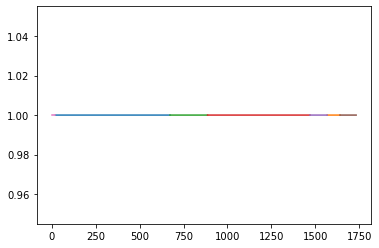

In [69]:
prefix = '/media/martin/Samsung_T5/data/endoscopic_data/cholec80'
phase_folder = os.path.join(prefix, 'phase_annotations')
tool_folder = os.path.join(prefix, 'tool_annotations')

phase_vids = scan2df(phase_folder, postfix='.txt')
tool_vids = scan2df(tool_folder, postfix='.txt')

idx = 0
phase_df = pd.read_csv(os.path.join(phase_vids['folder'][idx], phase_vids['files'][idx]), sep='\t')
tool_df = pd.read_csv(os.path.join(phase_vids['folder'][idx], phase_vids['files'][idx]), sep='\t')

phase_df = phase_df.groupby('Phase')

fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

fps = 25
for key in phase_df.groups:
    plt.plot(phase_df.groups[key]/fps, np.ones(len(phase_df.groups[key])), label=key)

plt.show()

ValueError: setting an array element with a sequence.